# Batch Optimization

We provide an example of how to update parameters on a batch of data. In these toy examples, we show different ways to update parameters of functions on data containing multiple inputs. For simplicity, we consider batch update without random sampling.

In [1]:
%pip install trace-opt

Looking in indexes: https://pypi.netflix.net/simple
Note: you may need to restart the kernel to use updated packages.


First, we consider a small linear regression problem. To perform updates on multiple inputs at a time, here we just compute the loss for each input and then sum it up, and perform one `backward` call to tell the optimizer to minimize the loss. Since the optimizer is capable of seeing the graph, it can understand how different inputs and labels are paired and evaluated by the loss function.

In [2]:
import random
import numpy as np

random.seed(0)
np.random.seed(0)

from opto import trace
from opto.optimizers import OptoPrime


def true_fun(x):
    return 2*x  - 3

inputs = [3, 2, 1, 5, 4]
outputs = [true_fun(x) for x in inputs]
N = len(inputs)


@trace.bundle()
def loss(y_hat, y):
    """ A least squares loss function. """
    return (y_hat - y) ** 2


def compute_loss(inputs, outputs):
    l = 0
    for x,y in zip(inputs, outputs):
        y_hat = fun(x)
        l += loss(y_hat, y)
    return l


Iteration 0 Loss: 85
Iteration 1 Loss: 10
Iteration 2 Loss: 10
Iteration 3 Loss: 7.5
Iteration 4 Loss: 122.8125
Iteration 5 Loss: 80.3125
Iteration 6 Loss: 12.8125
Iteration 7 Loss: 10.0
Iteration 8 Loss: 7.5
Iteration 9 Loss: 8.150000000000002
Iteration 10 Loss: 6.449999999999999
Iteration 11 Loss: 8.150000000000002
Iteration 12 Loss: 9.037500000000001
Iteration 13 Loss: 9.427


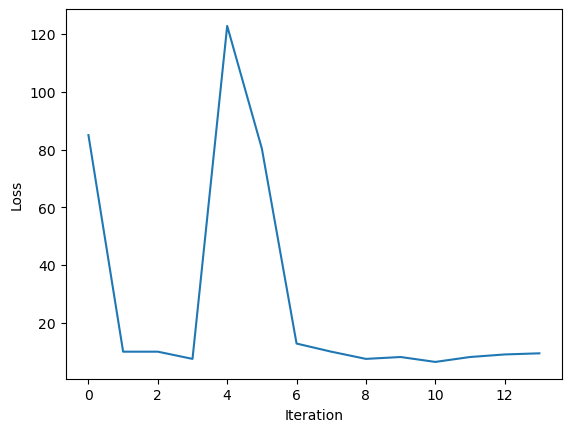

In [3]:
trace.GRAPH.clear()

@trace.bundle(trainable=True)
def fun(x):
    """ A linear predictor function """
    return 0

optimizer = OptoPrime(fun.parameters())

ls = []
for i in range(15):
    try:
        l = compute_loss(inputs, outputs)
        target = l
        feedback = 'Minimize loss'
        print(f'Iteration {i} Loss: {l.data}')
        ls.append(l.data)
    except trace.ExecutionError as e:
        target = e.exception_node
        feedback = str(e.exception_node.data)

    optimizer.zero_feedback()
    optimizer.backward(target, feedback)
    optimizer.step()

# plot ls
import matplotlib.pyplot as plt
plt.plot(ls)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

In contrast, if we update the parameter without batching but in a purely online fashion one by one, then the optimization results can be more noisy sometimes.

Iteration 0 Loss: 85
Iteration 1 Loss: 15
Iteration 2 Loss: 10
Iteration 4 Loss: 10
Iteration 5 Loss: 6
Iteration 6 Loss: 6
Iteration 7 Loss: 5
Iteration 8 Loss: 5
Iteration 9 Loss: 1
Iteration 10 Loss: 0
Iteration 11 Loss: 0
Iteration 12 Loss: 0
Iteration 13 Loss: 9
Iteration 14 Loss: 120


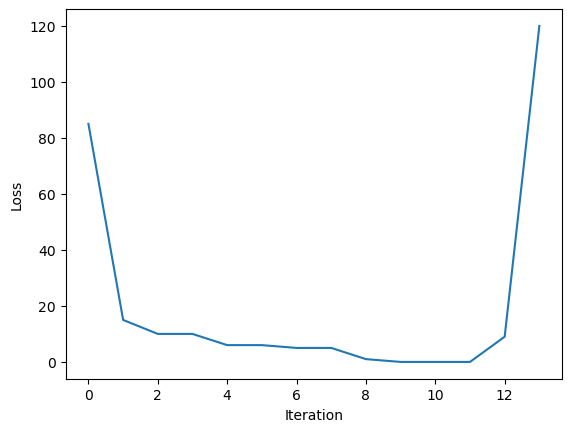

In [4]:


trace.GRAPH.clear()

@trace.bundle(trainable=True)
def fun(x):
    """ A linear predictor function """
    return 0

optimizer = OptoPrime(fun.parameters())

ls = []
for i in range(15):
    try:
        l_eval = compute_loss(inputs, outputs)
        print(f'Iteration {i} Loss: {l_eval.data}')
        ls.append(l_eval.data)

        ind = np.random.randint(0, N) % N
        target = compute_loss([inputs[ind]], [outputs[ind]])
        feedback = 'Minimize loss'
    except trace.ExecutionError as e:
        target = e.exception_node
        feedback = str(e.exception_node.data)

    optimizer.zero_feedback()
    optimizer.backward(target, feedback)
    optimizer.step()



# plot ls
import matplotlib.pyplot as plt
plt.plot(ls)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()


### Batching Non-Commutative Feedbacks

In the earlier numerical example, the loss function was commutative so that we can do  `batch_loss += loss(each_input)`. What if the feedbacks received are not commutative? This can happen often with non-numeric (e.g. text) feedbacks. Here we will see a simple design pattern for using `trace` and `OptoPrime` for batch optimization in such cases.

In [5]:
from opto.trace import bundle

@bundle(trainable=False)
def concat(*items):
    """ Concatenate the items into a single string """
    output = ''
    for i, item in enumerate(items):
        output += f'ID {[i]}: {item}\n'
    return output

Note that the `concat` function when called with a list of feedbacks will concatenate them all with an identifier for each element. This way, the optimizer when given a batch of outputs and a corresponding batch of feedbacks can disambiguate which feedback corresponds to which output.

In [6]:
@bundle(trainable=True)
def strange_sort_list(lst):
    '''
    Given list of integers, return list in strange order.
    Strange sorting, is when you start with the minimum value,
    then maximum of the remaining integers, then minimum and so on.
    '''
    lst = sorted(lst)
    return lst

def get_feedback(predict, target):
    if predict == target:
        return "test case passed!"
    else:
        return "test case failed!"
    
from opto.optimizers import OptoPrime

test_ground_truths = [[1, 4, 2, 3], [5, 5, 5, 5], [], [4, 9, 5, 8, 6, 7]]
test_inputs = [[1, 2, 3, 4], [5, 5, 5, 5], [], [9, 8, 7, 6, 5, 4]]

optimizer = OptoPrime(strange_sort_list.parameters())

outputs = []
feedbacks = []
for i in range(len(test_inputs)):
    try:
        test_output = strange_sort_list(test_inputs[i])
        feedback = get_feedback(test_output, test_ground_truths[i])
    except trace.ExecutionError as e:
        feedback = e.exception_node.data
        test_output = e.exception_node
    feedbacks.append(feedback)
    
    correctness = test_output.eq(test_ground_truths[i])
    outputs.append(correctness)

batched_feedback = concat(*feedbacks)
batched_outputs = concat(*outputs)
optimizer.zero_feedback()
optimizer.backward(batched_outputs, batched_feedback.data)
optimizer.step(verbose=True)

Prompt
 
You're tasked to solve a coding/algorithm problem. You will see the instruction, the code, the documentation of each function used in the code, and the feedback about the execution result.

Specifically, a problem will be composed of the following parts:
- #Instruction: the instruction which describes the things you need to do or the question you should answer.
- #Code: the code defined in the problem.
- #Documentation: the documentation of each function used in #Code. The explanation might be incomplete and just contain high-level description. You can use the values in #Others to help infer how those functions work.
- #Variables: the input variables that you can change.
- #Constraints: the constraints or descriptions of the variables in #Variables.
- #Inputs: the values of other inputs to the code, which are not changeable.
- #Others: the intermediate values created through the code execution.
- #Outputs: the result of the code output.
- #Feedback: the feedback about the code